<a href="https://colab.research.google.com/github/olenash/AutoML/blob/master/AutoMLEx1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install GPy
!pip install GPyOpt

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

In [19]:
#import optimizers
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [20]:
X, y = load_diabetes(return_X_y=True)
print("X.shape:", X.shape)
print("Y.shape:", y.shape)

X.shape: (442, 10)
Y.shape: (442,)


In [21]:
from sklearn.model_selection import cross_val_score
baseline = cross_val_score(RandomForestRegressor(), X,y, scoring='neg_mean_squared_error').mean()

In [22]:
baseline

-3373.0296618539323

In [23]:
max_features = ['auto', 'sqrt', 'log2']
n_estimators = [50,80,100,150,250,500]
max_depth = [1,2,3,4,5]

In [24]:
grid_parametrs = {'max_features':max_features,
'n_estimators':n_estimators,
'max_depth': max_depth}

In [25]:
reg = RandomForestRegressor(random_state=1)

Random Search

In [26]:
RandomFR = RandomizedSearchCV(reg,grid_parametrs,scoring='neg_mean_squared_error', n_iter=20)
RandomFR.fit(X,y)
print(RandomFR.best_params_)

{'n_estimators': 500, 'max_features': 'log2', 'max_depth': 5}


Grid Search

In [27]:
GridFR = GridSearchCV(reg,grid_parametrs,scoring='neg_mean_squared_error')
GridFR.fit(X,y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [28]:
print(GridFR.best_params_)

{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 150}


Bayesian Optimization


In [29]:
def estimate(param_tensor):
    max_features_k, n_estimators,max_depth  = param_tensor[0]
    max_features_p = {1:'auto', 2:'sqrt', 3: 'log2'}
    max_features = max_features_p[max_features_k]
    reg = RandomForestRegressor(max_depth=int(max_depth), n_estimators=int(n_estimators), max_features=max_features)
    reg.fit(X,y)
    score = cross_val_score(reg, X,y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [30]:
bds = [{'name':'max_features', 'type':'discrete', 'domain':(1,2,3)},
       {'name':'n_estimators', 'type':'discrete', 'domain':(50,80,100,150,250,500)},
       {'name':'max_depth', 'type':'discrete', 'domain':(1,2,3,4,5)}]

optimizer = BayesianOptimization(f=estimate, model_type='GP', acquisition_type='EI', domain=bds, maximize=True)
optimizer.run_optimization(max_iter=20)

In [31]:
optimizer.plot_acquisition()

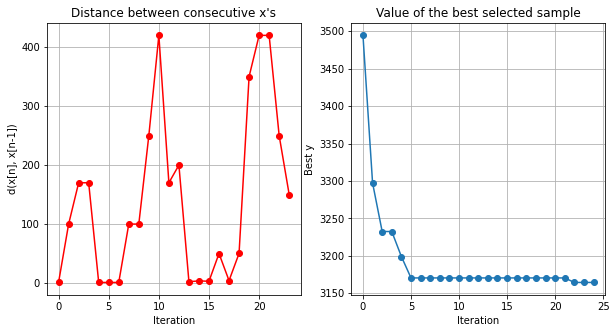

In [32]:
optimizer.plot_convergence()

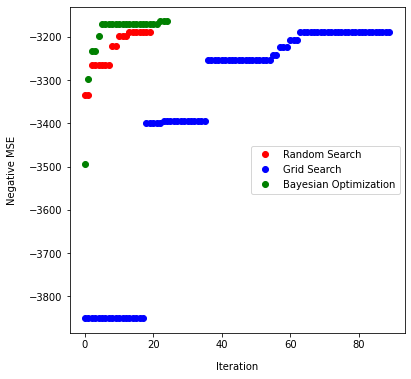

In [39]:
y_rs = np.maximum.accumulate(RandomFR.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(GridFR.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

plt.figure(figsize=(6,6))
plt.plot(y_rs, 'ro', label='Random Search')
plt.plot(y_gs, 'bo', label='Grid Search')
plt.plot(y_bo, 'go', label='Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='right');

We hit the 'optimal' solution with a Bayesian Optimization much faster then with other algorithms and it seems to have showed better Negative MSE.